# CryptoDataPy 

`v0.0.1` 

Last Updated: 2022-09-22

**CryptoDataPy** allows you to create high quality data sets ready for analysis from a variety of sources with only a few lines of code. The easy to use interface facilitates each step of the ETL (extract-transform-load) process, saving you time and effort from having to spend countless hours studying documentation, extracting data from different file formats and sources, as well as wrangling and cleaning the data.

In this notebook, we will walk through how to use **CryptoDataPy** to query various types of data from multiple sources and get it ready for data analysis. 


## Table of Contents:
### Use Cases:
- [Long/short strategies](#long-short): collect perpetual futures prices for long/short algo trading strategy development, and extend sample history back using aggregate exchange spot prices.
- [Data cleaning](#data-cleaning): clean on-chain data in a few lines of code.
- [Stablecoin analysis](#stablecoins): get key indicators for the largest stablecoins.


### Objects:
- [Data Catalog](#data-catalog): `DataCatalog` allows you to **explore what data is available** and understand it better.
- [Data Request](#data-request): `DataRequest` provides an intuitive parameter interface which allows you to **specify the parameter values** for the data you want.
- [Get Data](#get-data): `GetData` **retrieves either metadata or time series data** from the data source for the parameters specified in the data request. 
- [Clean Data](#clean-data): `CleanData` provides **tools for data cleaning** including: filtering and repairing outliers, filtering assets trading below an average traded value (liquidity), removing observations with long periods of missing values, removing tickers with short price histories (minimum number of observations), and removing specific tickers to be excluded from the analysis (e.g. stablecoins).

# Long/Short Strategies <a class="anchor" id="long-short"></a>

Let's collect market and funding rate data for long/short algo trading strategy research. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Step 1: Define Asset Universe


Let's start by collecting our data.

First, we need to import `DataRequest` and `GetData` and select a data source to pull metadata from it using the `get_asset_info` method.

This will allow us to create a tickers list for our asset universe.


In [2]:
from cryptodatapy.extract.datarequest import DataRequest
from cryptodatapy.extract.getdata import GetData

Let's get a list of tickers for the universe of assets with perpetual futures contracts trading on binance, the most liquid cryptoasset exchange.

In [3]:
data_req = DataRequest(source='ccxt')
perp_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binanceusdm', as_list=True)

Which gives us an asset universe of 150 + cryptoassets to trade.

In [4]:
len(perp_tickers)

193

## Step 2: Get Perpetual Futures Data


Next, let's create a data request for both market prices and funding rates for those perpetual futures tickers, using only the first 10 tickers for illustrative purposes.

**Note**: using the `source_tickers` parameter is recommended when the tickers are already in the data source's format. If data source's format is not known, CryptoDataPy will convert tickers to source tickers automatically.

In [5]:
data_req = DataRequest(source='ccxt',
                       source_tickers=perp_tickers[:10], 
                       fields=['close', 'volume', 'funding_rate'], 
                       mkt_type='perpetual_future', 
                       freq='d')

We can now retrieve this data request using the `GetData` object and the `get_series` method.

In [6]:
df = GetData(data_req).get_series()

In [7]:
df.head()

,,close,volume,funding_rate
date,ticker,,,
2019-09-08,BTC,10391.63,3096.291,<NA>
2019-09-09,BTC,10307.0,14824.373,<NA>
2019-09-10,BTC,10102.02,9068.955,<NA>
2019-09-11,BTC,10159.55,10897.922,0.0003
2019-09-12,BTC,10415.13,15609.634,0.0003


## Step 3: Extend Sample Size with Spot Data

Since perpetual futures only started trading in 2019 on Binance, this gives us a limited sample size for quantitative research. Let's extend it back using spot prices from another data source.

We will need to replace the market tickers with base asset tickers first from aggregate exchange prices on CryptoCompare before pulling the data.

In [8]:
cc_tickers = [ticker.split('/')[0] for ticker in perp_tickers]

In [9]:
data_req = DataRequest(source='cryptocompare',
                       tickers=cc_tickers[:10], 
                       fields=['close', 'volume'], 
                       mkt_type='spot', 
                       freq='d')

In [10]:
df1 = GetData(data_req).get_series()

We can now combine the two datasets to extend our history back to 2010.

In [11]:
df = df.unstack().combine_first(df1.unstack()).stack()

In [12]:
df.head()

,,close,funding_rate,volume
date,ticker,,,
2010-07-17,BTC,0.04951,<NA>,20.0
2010-07-18,BTC,0.08584,<NA>,75.01
2010-07-19,BTC,0.0808,<NA>,574.0
2010-07-20,BTC,0.07474,<NA>,262.0
2010-07-21,BTC,0.07921,<NA>,575.0


## Step 4: Filter Asset Universe

Lastly, we may want to filter this asset universe by:

- identifying and repairing outliers
- removing low trading volume cryptoassets (< $10 mil USD average traded volume)
- removing cryptoassets with a limited data history (< 100 observations)

We will need to import `CleanData` to use the filter methods available.


In [13]:
# import CleanData 
from cryptodatapy.transform.clean import CleanData

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [14]:
# Filter data
clean_df = CleanData(df).filter_outliers(od_method='mad').\
                         repair_outliers(imp_method='interpolate').\
                         filter_avg_trading_val(thresh_val=10000000).\
                         filter_missing_vals_gaps().\
                         filter_min_nobs().get(attr='df')

In [15]:
clean_df.dropna(how='all').head()

,,close,funding_rate,volume
date,ticker,,,
2014-12-09,BTC,352.19,<NA>,43827.16
2014-12-10,BTC,347.94,<NA>,27133.46
2014-12-11,BTC,347.68,<NA>,51080.97
2014-12-12,BTC,353.4,<NA>,26850.92
2014-12-17,BTC,320.02,<NA>,61338.52


We have extended our data sample by an extra 5 years and are now ready to do some long/short algo trading strategy research!

# Data Cleaning <a class="anchor" id="data-cleaning"></a>

Cryptoassets create a lot of data, but the data can have a lot of outliers and irregularities that can wreak havoc with predictive/ML models down stream. This is especially true for on-chain data and off-chain data, as well as higher frequency market data.

This makes data cleaning and important part of any high quality cryptoasset data pipeline.

## Step 1: Data Extraction


Let's start by collecting our data.




In [16]:
# glassnode
data_req = DataRequest(source='glassnode', 
                       tickers=['btc', 'eth'], 
                       fields=['close', 'add_act', 'hashrate'], 
                       freq='d',
                      start_date='2016-01-01')

In [17]:
df = GetData(data_req).get_series()

With same data request parameters, can you retrieve the same data from other sources for comparison.

In [18]:
# coinmetrics
data_req = DataRequest(source='coinmetrics', 
                       tickers=['btc', 'eth'], 
                       fields=['close', 'add_act', 'hashrate'], 
                       freq='d',
                      start_date='2016-01-01')
df1 = GetData(data_req).get_series()

In [19]:
# cryptocompare
data_req = DataRequest(source='cryptocompare', 
                       tickers=['btc', 'eth'], 
                       fields=['close', 'add_act', 'hashrate'], 
                       freq='d',
                      start_date='2016-01-01')
df2 = GetData(data_req).get_series()

## Step 2: Visual Data Inspection

Next, we can plot the series from various sources to compare them.

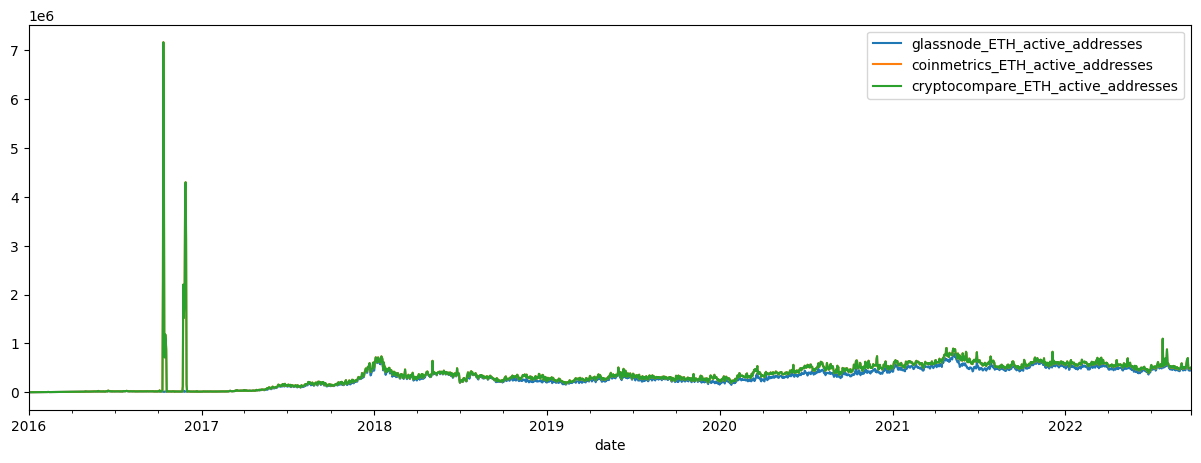

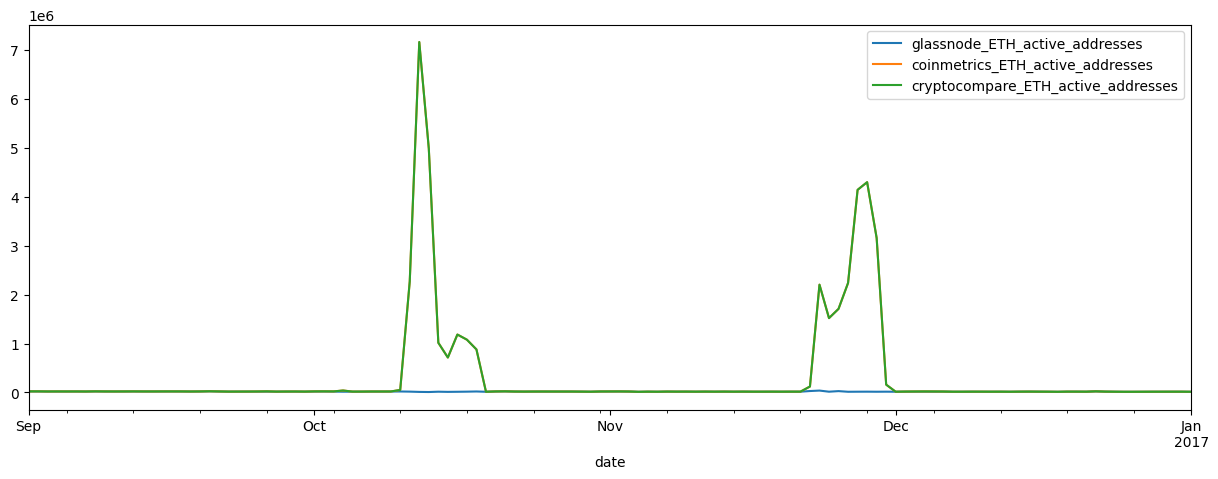

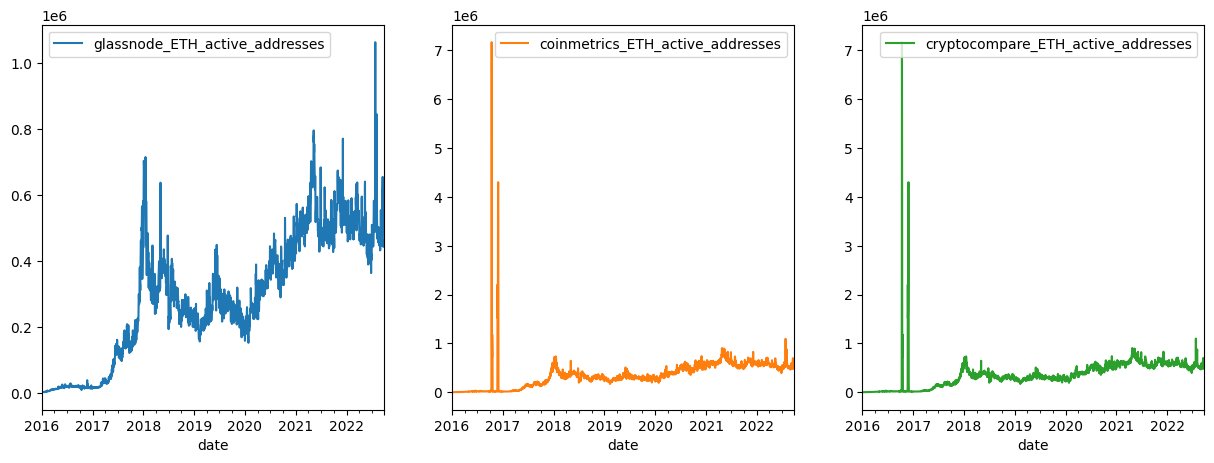

In [20]:
# concat dfs
df3 = pd.concat([df, df1, df2], axis=1)
add_act_df = df3.loc[pd.IndexSlice[:, 'ETH'], 'add_act'].droplevel(1)
# rename cols
col_names = [vendor + '_' + 'ETH_' + 'active_addresses' for vendor in ['glassnode', 'coinmetrics', 'cryptocompare']]
add_act_df.columns = col_names
# plot active addresses
add_act_df.plot(figsize=(15,5))
add_act_df.loc['2016-09-01':'2017-01-01'].plot(figsize=(15,5))
add_act_df.plot(subplots=True, layout=(1,3), figsize=(15,5))
plt.legend(loc='upper right');

Comparing the three active address series, we notice that both the Cryptocompare and Coinmetrics active addresses appear to have **large outliers in ETH active addresses** in late 2016. 

Large outliers can cause major distortions down stream in any machine learning or predictive process so cleaning this data before doing so is a necessary next step.

## Step 3: Data Cleaning

Once outliers are detected through visual data inspection, they can be filtered and repaired by importing **CryptoDataPy**'s `CleanData` module. 

We have several options:

1. **Use the series without large outliers**.
2. **Filter the outliers using one of CryptoDataPy's outlier detection methods** (shown below) and keeping the 'clean' series.
3. **Combine 1 and 2**, e.g. filtering and repairing outliers using outlier detection and missing values imputation algorithms, and then taking the median (or some other measure of central tendency) from the resulting series as the representative 'true series'(also shown below).

In [21]:
# import CleanData module
from cryptodatapy.transform.clean import CleanData

Here, we will use the **STL outlier detection algorithm**, similar to the one used by [Twitter](https://blog.twitter.com/engineering/en_us/a/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series) to filter/remove outliers, and then use the **interpolation method** for repair of bad data/missing values.

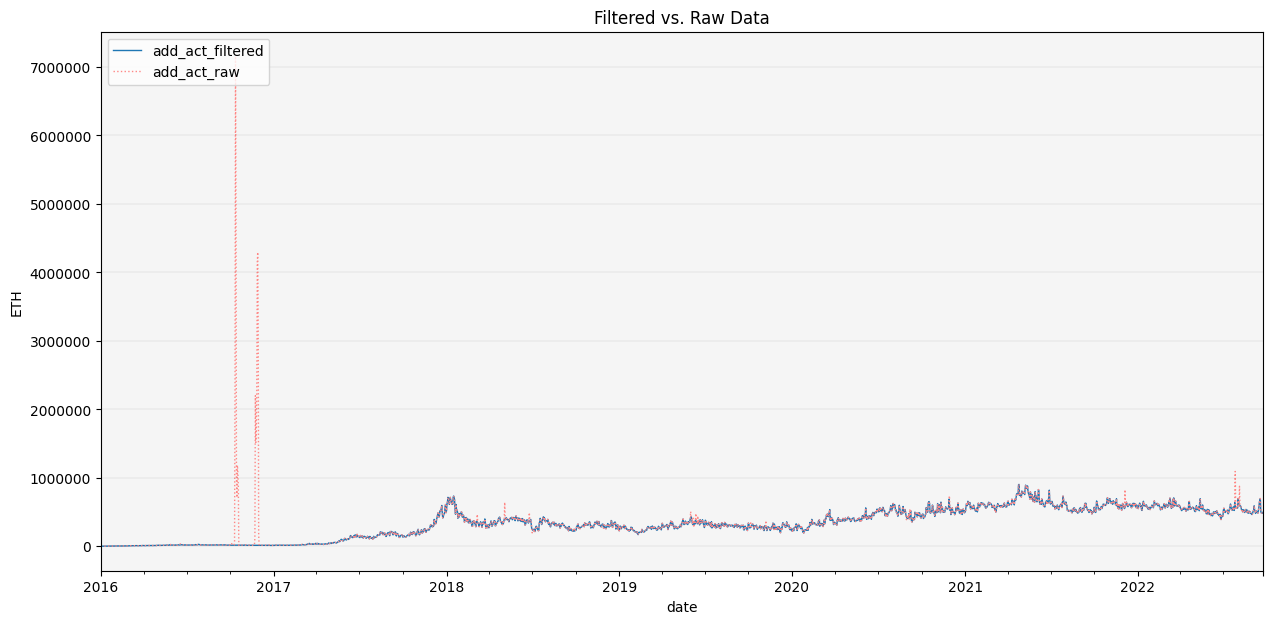

In [22]:
# filter coinmetrics data 
# show raw vs filtered plot
CleanData(df1).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').show_plot(plot_series=('ETH', 'add_act'))
# save filtered df
clean_df1 = CleanData(df1).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').get(attr='df')

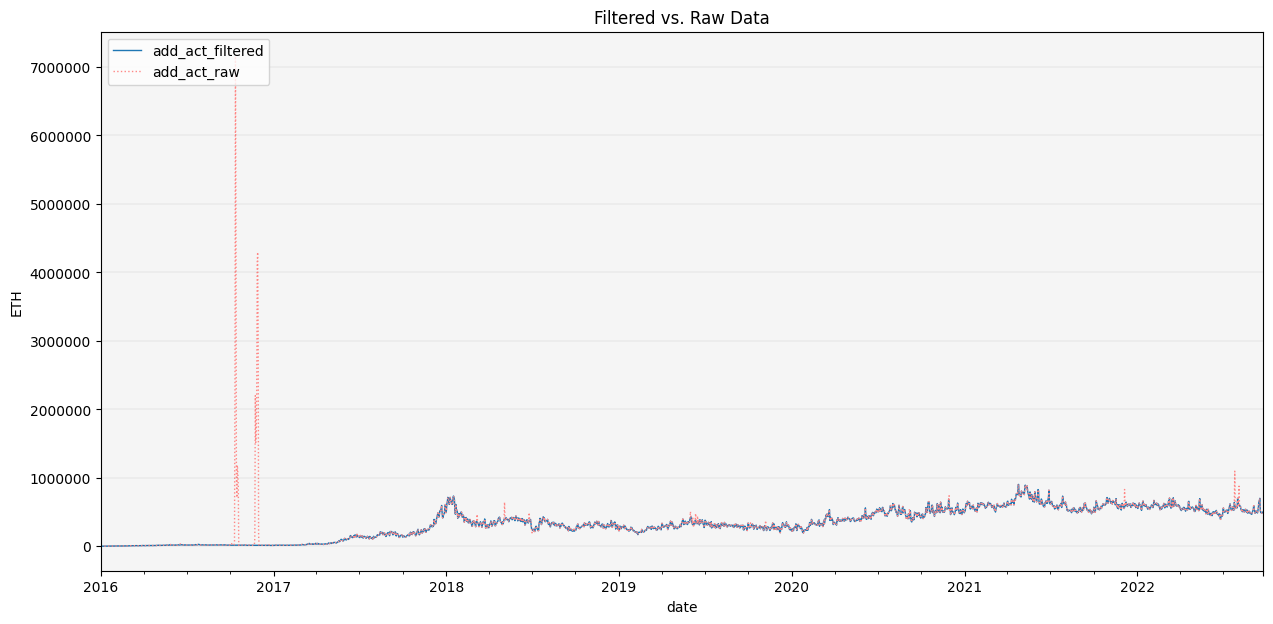

In [23]:
# filter cryptocompare data 
# show raw vs filtered plot
CleanData(df2).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').show_plot(plot_series=('ETH', 'add_act'))
# save filtered df
clean_df2 = CleanData(df2).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').get(attr='df')

Let's visually inspect the data once again to assess data quality.

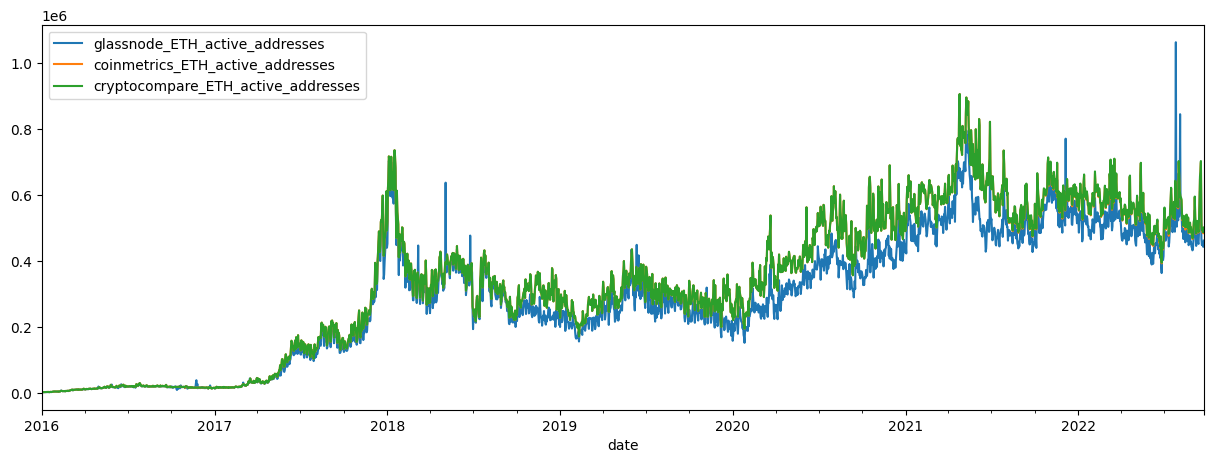

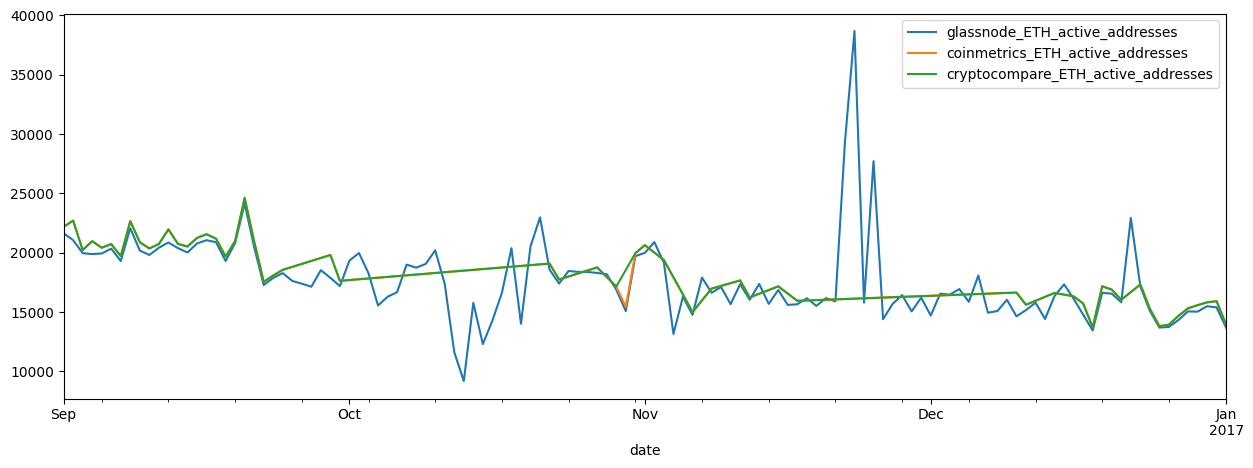

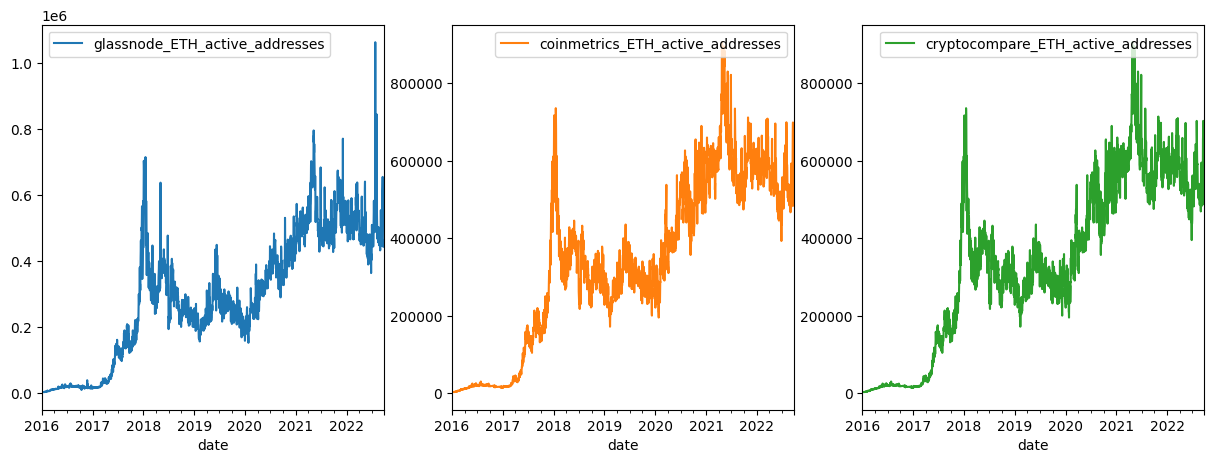

In [24]:
# concat dfs
df_clean = pd.concat([df, clean_df1, clean_df2], axis=1)
add_act_df1 = df_clean.loc[pd.IndexSlice[:, 'ETH'], 'add_act'].droplevel(1)
# rename cols
col_names = [vendor + '_' + 'ETH_' + 'active_addresses' for vendor in ['glassnode', 'coinmetrics', 'cryptocompare']]
add_act_df1.columns = col_names
# plot active addresses
add_act_df1.plot(figsize=(15,5))
add_act_df1.loc['2016-09-01':'2017-01-01'].plot(figsize=(15,5))
add_act_df1.plot(subplots=True, layout=(1,3), figsize=(15,5))
plt.legend(loc='upper right');

These data cleaning algorithms do a good job of filtering and repairing large outliers as we can see.

We can now use one of the 'cleaned' data sets for data analysis, or alternatively, **use all 3 series to construct a 'series of truth'** which uses the median of the 3 time series.

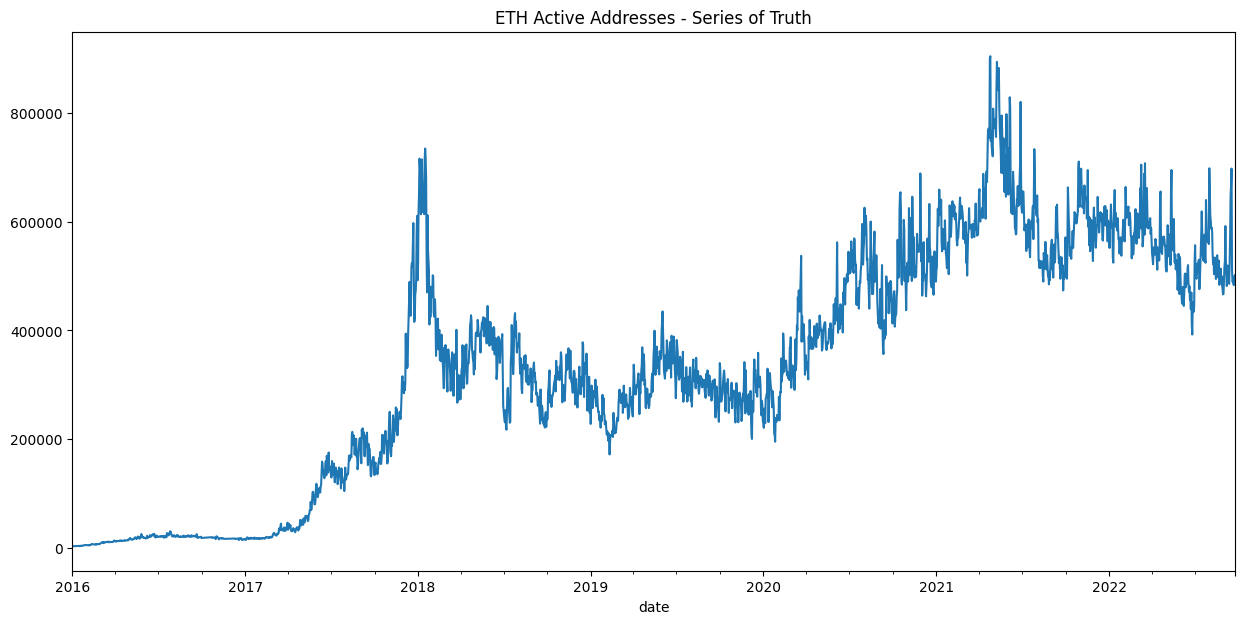

In [25]:
# plot series of truth
df_clean.add_act.median(axis=1).unstack()['ETH'].plot(title='ETH Active Addresses - Series of Truth', figsize=(15,7));

You are now ready to begin exploring, analyzing and predicting with clean data!

# Stablecoin Analysis <a class="anchor" id="stablecoins"></a>

Stablecoins are a growing and import part of the cryptoeconomic ecosystem. The recent failures of some stablecoin projects and the broader impact this can have on the ecosystem makes risk monitoring and analysis of stablecoins increasingly import.

**CrptoDataPy** makes it easy to find data on stablecoins.

The `DataCatalog` allows us to find information on the largest stablecoins by market cap.

In [26]:
from cryptodatapy.util.datacatalog import DataCatalog 
dc = DataCatalog()

If we want to get metadata

In [27]:
sc_meta = dc.get_tickers_metadata(cat='crypto')

In [28]:
sc_meta.head()

,name,description,url,country_id_2,country_id_3,country_name,agg,category,subcategory,mkt_type,frequency,tenor,unit,quote_ccy,tiingo_id,fred_id,dbnomics_id,investpy_id
ticker,,,,,,,,,,,,,,,,,,
USDT,Tether USDT,USDT is a cryptocurrency asset issued on the B...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
USDC,USD Coin,USD CoinÂ (USDC) is a fully collateralized US ...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
BUSD,Binance USD,Binance USD (BUSD) is a stable coin pegged to ...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
DAI,Dai DAI,"The Maker Protocol, also known as the Multi-Co...",NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
FRAX,Frax FRAX,Frax attempts to be the first stablecoin proto...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN


Or we can get a list of stablecoins

In [29]:
sc_list = dc.get_tickers_metadata(cat='crypto', as_list=True)

In [30]:
sc_list[:10]

['CADC',
 'MIMATIC',
 'JEUR',
 'USDP',
 'SEUR',
 'EURS',
 'USDB',
 'OUSD',
 'PAR',
 'YUSD']

If instead we want an updated stablecoin list, we can use the `scrape_stablecoins` method to scrape stablecoin information for various source. The information will be returned to us sorted by market cap.

In [31]:
sc_scraped = dc.scrape_stablecoins(source='coinmarketcap')

[WDM] - Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8.15M/8.15M [00:00<00:00, 32.3MB/s]


In [32]:
sc_scraped.head()

,name,price,24h_%_chg,7d_%_chg,mkt_cap,volume_24h,circ_suppkly
ticker,,,,,,,
USDT,Tether,1.0000,0.0001,0.0000,6.795931e+10,3.915201e+21,6.795470e+10
USDC,USD Coin,0.9999,0.0002,0.0002,4.971175e+10,3.887546e+19,4.971466e+10
BUSD,Binance USD,0.9998,0.0005,0.0005,2.051343e+10,7.511201e+19,2.051725e+10
DAI,Dai,0.9992,0.0014,0.0009,6.926324e+09,2.449716e+17,6.931712e+09
FRAX,Frax,0.9967,0.0040,0.0026,1.351492e+09,2.212364e+13,1.355966e+09


In [33]:
top_sc_list = sc_scraped.index.to_list()[:5]

We can take the top 5 stablecoins by market cap and we can find out which ones have available data selecting from a specific source.

In [34]:
cm_assets = GetData(DataRequest(source='coinmetrics')).get_meta(attr='assets')

In [35]:
cm_sc_list = [asset for asset in cm_assets if asset.upper() in top_sc_list]

Coinmetrics provides data on all of them

In [36]:
len(cm_sc_list)

5

We can then narrow it down further to the assets with circulating supply data, a key metric for stablecoin health.

In [37]:
data_req = DataRequest(source='coinmetrics', tickers=cm_sc_list, fields=['supply_circ', 'ref_rate_usd'])

In [38]:
cm_supply_list = GetData(data_req).get_meta(method='get_onchain_tickers_list', data_req=data_req)

In [39]:
cm_sc_list = [asset for asset in cm_supply_list if asset.upper() in top_sc_list]

In [40]:
cm_sc_list

['usdt', 'dai', 'busd', 'usdc']

Finally, we can pull circulationg supply for those stablecoins

In [41]:
data_req = DataRequest(source='coinmetrics', tickers=cm_sc_list, fields=['supply_circ', 'ref_rate_usd'])

In [42]:
df = GetData(data_req).get_series()

In [43]:
df.head()

,,supply_circ,ref_rate_usd
date,ticker,,
2013-12-29,USDT,<NA>,0.997938
2013-12-30,USDT,<NA>,1.004237
2013-12-31,USDT,<NA>,0.996674
2014-01-01,USDT,<NA>,0.990799
2014-01-02,USDT,<NA>,0.995514


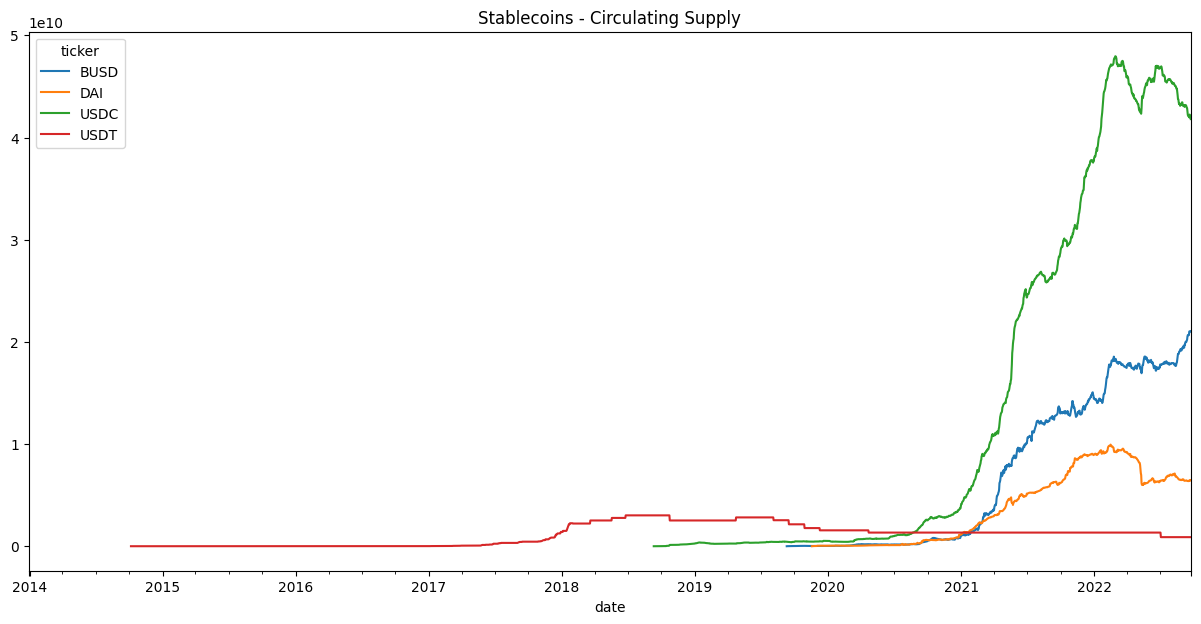

In [44]:
df.unstack().supply_circ.plot(title='Stablecoins - Circulating Supply', figsize=(15,7));

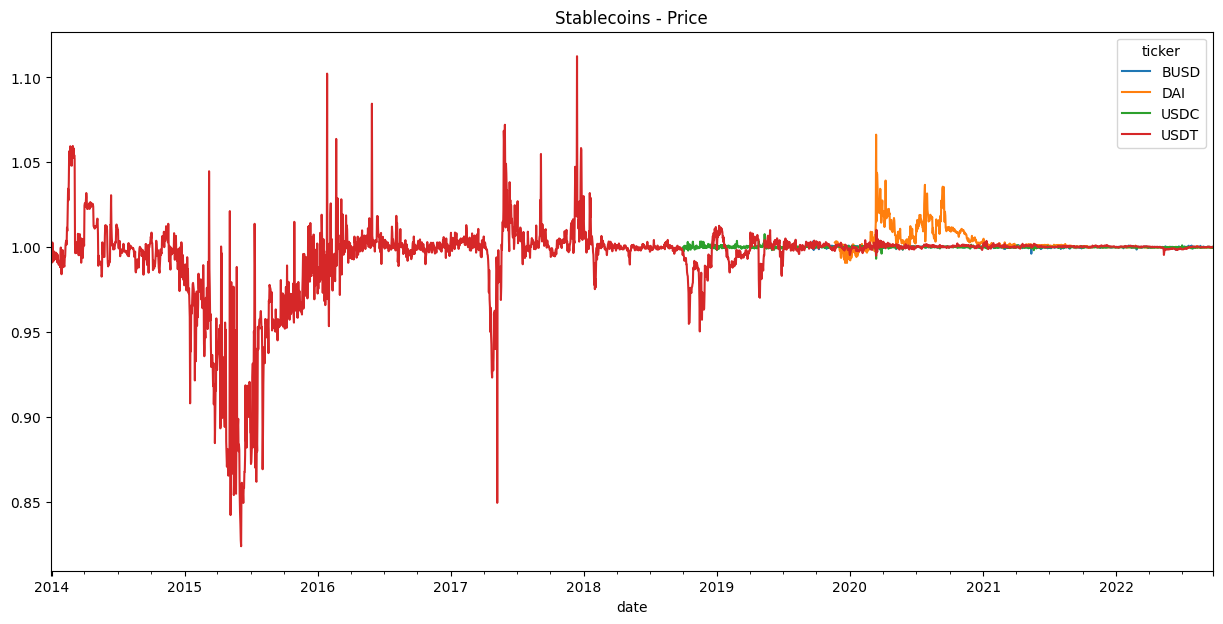

In [45]:
df.unstack().ref_rate_usd.plot(title='Stablecoins - Price', figsize=(15,7));

You are now ready to monitor key indicators for stablecoins!

For a deeper dive on how to maximize your use of **CryptoDataPy**, we explore how to use each one of it's objects below.

# Data Catalog <a class="anchor" id="data-catalog"></a>

The `DataCatalog` allow us to explore what data is available and understand it better.

It includes the following attributes and methods:

- [Data sources](#data-sources): the `data_sources` attribute retrieves information on all the available data sources. 
- [Metadata](#metadata): the `get_tickers_metadata` method retrieves information on available tickers. The `get_fields_metadata` method retrieves information on available fields. 
- [Search](#search): the `search_tickers` method allows you to search for tickers by ticker, country, country id, asset class, etc. The `search_fields` method allows you to search for fields by name, id, category, etc. It also provides identifiers for each data source.
- [Stablecoins](#stablecoins): the `scrape_stablecoins` method scrapes information on stablecoins from the selected source. 

To access the data catalog, instantiate a DataCatalog object.

In [46]:
from cryptodatapy.util.datacatalog import DataCatalog 
dc = DataCatalog()

### Data Sources <a class="anchor" id="data-sources"></a>

Available `data sources` 


In [47]:
dc.data_sources

{'ccxt': 'https://github.com/ccxt/ccxt',
 'cryptocompare': 'https://min-api.cryptocompare.com/documentation',
 'coinmetrics': 'https://docs.coinmetrics.io/info/markets',
 'glassnode': 'https://glassnode.com/',
 'tiingo': 'https://api.tiingo.com/products/crypto-api',
 'yahoo finance': 'https://finance.yahoo.com/',
 'investpy': 'https://investpy.readthedocs.io/',
 'dbnomics': 'https://db.nomics.world/providers',
 'fred': 'https://fred.stlouisfed.org/'}

### Metadata<a class="anchor" id="metadata"></a>

Available tickers can be accessed with the `get_tickers_metadata` method.

**Note**: cryptoasset and individual equity tickers are not listed in the tickers metadata due to a large number of assets. They can be accessed by calling the data source object and using the `get_assets_info` method to see available tickers.

In [48]:
dc.get_tickers_metadata().head()

,name,description,url,country_id_2,country_id_3,country_name,agg,category,subcategory,mkt_type,frequency,tenor,unit,quote_ccy,tiingo_id,fred_id,dbnomics_id,investpy_id
ticker,,,,,,,,,,,,,,,,,,
ARS,Argentine Peso,"Argentine Peso vs. quote currency, spot exchan...",NaN,AR,ARG,Argentina,EM,fx,spot rate,spot,tick,NaN,foreign currency per unit of domestic currrency,NaN,ARS,NaN,NaN,NaN
AUD,Australian Dollar,"Australian Dollar vs. quote currency, spot exc...",NaN,AU,AUS,Australia,DM,fx,spot rate,spot,tick,NaN,foreign currency per unit of domestic currrency,NaN,AUD,NaN,NaN,NaN
EUR,Euro,"Euro vs. quote currency, spot exchange rate",NaN,AT,AUT,Austria,DM,fx,spot rate,spot,tick,NaN,foreign currency per unit of domestic currrency,NaN,EUR,NaN,NaN,NaN
EUR,Euro,"Euro vs. quote currency, spot exchange rate",NaN,BE,BEL,Belgium,DM,fx,spot rate,spot,tick,NaN,foreign currency per unit of domestic currrency,NaN,EUR,NaN,NaN,NaN
BDT,Bangladeshi Taka,"Bangladeshi Taka vs. quote currency, spot exch...",NaN,BD,BGD,Bangladesh,NaN,fx,spot rate,spot,tick,NaN,foreign currency per unit of domestic currrency,NaN,BDT,NaN,NaN,NaN


Available fields can be accessed with the `get_fields_metadata` method.

In [49]:
dc.get_fields_metadata().head()

,name,description,category,subcategory,freq,unit,data_type,cryptocompare_id,coinmetrics_id,ccxt_id,glassnode_id,tiingo_id,investpy_id,dbnomics_id,fred_id,av-daily_id,av-forex-daily_id,yahoo_id
id,,,,,,,,,,,,,,,,,,
date,date,date and time,all,none,all,YYYY-MM-DD-HH:MM:SS,DatetimeIndex,time,time,datetime,t,date,Date,period,DATE,index,index,Date
ticker,ticker symbol,ticker symbol for asset or index,all,none,all,none,string,symbol,market,symbol,NaN,ticker,NaN,NaN,symbol,ticker,ticker,Symbols
bid,best bid price,highest price that a buyer is willing to pay f...,market,quotes,tick,quote currency units,Float64,NaN,bid_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ask,best ask price,lowest price that a seller is willing to sell ...,market,quotes,tick,quote currency units,Float64,NaN,ask_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bid_size,bid size,The quantity/size of the highest price bid,market,quotes,tick,asset units,Float64,NaN,bid_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Search <a class="anchor" id="search"></a>

We can search for tickers with the `search_tickers` method by column name and keyword.

Let's look for tickers with assets in the US.

In [50]:
dc.search_tickers(by_col='country_id_2', keyword='US').head()

,name,description,url,country_id_2,country_id_3,country_name,agg,category,subcategory,mkt_type,frequency,tenor,unit,quote_ccy,tiingo_id,fred_id,dbnomics_id,investpy_id
ticker,,,,,,,,,,,,,,,,,,
USD,Us Dollar,"Us Dollar vs. quote currency, spot exchange rate",NaN,US,USA,United States,DM,fx,spot rate,spot,tick,NaN,foreign currency per unit of domestic currrency,NaN,USD,NaN,NaN,NaN
USD_TWI,"US Dollar Trade-Weighted Index, Nominal Broad","The trade-weighted US dollar index, also known...",https://fred.stlouisfed.org/series/DTWEXBGS,US,USA,United States,DM,fx,index,spot,d,NaN,trade-weighted index,USD,NaN,DTWEXBGS,NaN,NaN
USD_Idx,US Dollar Index Spot,"The Ice U.S. Dollar Index (USDX, DXY, DX, or i...",https://www.theice.com/forex/usdx,US,USA,United States,DM,fx,index,spot,tick,NaN,weighted-index,USD,NaN,NaN,NaN,US Dollar Index
USD_Idx_Fut,"US Dollar Index Futures, USDX","The Ice U.S. Dollar Index (USDX, DXY, DX, or i...",https://www.theice.com/products/194/US-Dollar-...,US,USA,United States,DM,fx,index,future,tick,NaN,weighted-index,USD,NaN,NaN,NaN,US Dollar Index Futures
USD_Idx_ETF,Invesco DB US Dollar Index Bullish Fund,The Invesco DB US Dollar Index Bullish (Fund) ...,https://www.invesco.com/us/financial-products/...,US,USA,United States,DM,fx,index,etf,tick,NaN,weighted-index,USD,UUP,NaN,NaN,NaN


The same can be done when searching for fields.

For example, let's look for avaialble on-chain data fields.

In [51]:
dc.search_fields(by_col='category', keyword='on-chain').head()

,name,description,category,subcategory,freq,unit,data_type,cryptocompare_id,coinmetrics_id,ccxt_id,glassnode_id,tiingo_id,investpy_id,dbnomics_id,fred_id,av-daily_id,av-forex-daily_id,yahoo_id
id,,,,,,,,,,,,,,,,,,
add_act,active addresses,number of unique addresses that were active in...,on-chain,addresses,"d, w, m, q",addresses,Int64,active_addresses,AdrActCnt,NaN,addresses/active_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN
add_act_new,new addresses,number of new unique addresses that were creat...,on-chain,addresses,"d, w, m, q",addresses,Int64,new_addresses,NaN,NaN,addresses/new_non_zero_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN
add_act_sent,active addresses sent,number of unique addresses that were active in...,on-chain,addresses,"d, w, m, q",addresses,Int64,NaN,AdrActSentCnt,NaN,addresses/sending_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN
add_act_rec,active addresses received,number of unique addresses that were active in...,on-chain,addresses,"d, w, m, q",addresses,Int64,NaN,AdrActRecCnt,NaN,addresses/receiving_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN
add_tot,total address count,number of unique addresses in the network at ...,on-chain,addresses,"d, w, m, q",addresses,Int64,unique_addresses_all_time,NaN,NaN,addresses/count,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Stablecoins<a class="anchor" id="stablecoins"></a>

We can find static info on stablecoins by using the `get_tickers_metadata` method and setting the `cat` parameter to 'crypto' 

In [52]:
dc.get_tickers_metadata(cat='crypto').head()

,name,description,url,country_id_2,country_id_3,country_name,agg,category,subcategory,mkt_type,frequency,tenor,unit,quote_ccy,tiingo_id,fred_id,dbnomics_id,investpy_id
ticker,,,,,,,,,,,,,,,,,,
USDT,Tether USDT,USDT is a cryptocurrency asset issued on the B...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
USDC,USD Coin,USD CoinÂ (USDC) is a fully collateralized US ...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
BUSD,Binance USD,Binance USD (BUSD) is a stable coin pegged to ...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
DAI,Dai DAI,"The Maker Protocol, also known as the Multi-Co...",NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN
FRAX,Frax FRAX,Frax attempts to be the first stablecoin proto...,NaN,WL,WLD,World,WL,crypto,stablecoin,spot,tick,NaN,fiat currency per unit of stablecoin,NaN,NaN,NaN,NaN,NaN


For dynamic/real-time info on stablecoins, we can scrape the data from CoinGecko or CoinMarketCap using the `scrape_stablecoins` method.

In [53]:
dc.scrape_stablecoins(source='coinmarketcap').head()

,name,price,24h_%_chg,7d_%_chg,mkt_cap,volume_24h,circ_suppkly
ticker,,,,,,,
USDT,Tether,1.0000,0.0001,0.0000,6.795931e+10,3.915201e+21,6.795470e+10
USDC,USD Coin,0.9999,0.0002,0.0002,4.971175e+10,3.887546e+19,4.971466e+10
BUSD,Binance USD,0.9998,0.0005,0.0005,2.051343e+10,7.511201e+19,2.051725e+10
DAI,Dai,0.9992,0.0014,0.0009,6.926324e+09,2.449716e+17,6.931712e+09
FRAX,Frax,0.9967,0.0040,0.0026,1.351492e+09,2.212364e+13,1.355966e+09


# Data Request <a class="anchor" id="data-request"></a>

`DataRequest` provides an intuitive parameter interface which allows you to **specify the parameter values** for the data you want.


By initializing a `DataRequest` object, we provide all the relevant parameters needed to retrieve data from the selected data source. `DataRequest` will automatically convert parameter values to the format required for each data source, allowing the user to experience a consistent and intuitive interface for every data source.

In [54]:
data_req = DataRequest(
    source='cryptocompare',  # provide the name of the supported data source, if not specified defaults to 'CCXT'
    tickers=['btc', 'eth'],  # ticker symbols, if not specified defaults to 'btc'
    freq = 'd',  # frequency of data, if not specified defaults to daily
    quote_ccy = 'USDT',  # quote currency, if not specified defaults to USD/USDT
    exch = None,  # exchance, if not specified defaults to aggregate 
    mkt_type = "spot",  # market type, if not specified defaults to spot
    start_date = None,  # start date, if not specified defaults to beginning of data history
    end_date = None,  # end date, if not specified defaults to end of data history
    fields = ["close", 'volume', "add_act"],  # data fields, if not specified defaults to close
    tz = None,  # timezone, if not specified defaults to 'UTC'
    inst = None,  # institution name, only necessary when retrieving data from institution, e.g. grayscale
    cat = None,  # category of asset or data, must be specified when data source provides data for many asset classes
    trials = 3,  # number of tries when requesting data, defaults to 3 
    pause = 0.1,  # pause between trials to avoid rate limits, defaults to 0.1 sec
    source_tickers = None,  # tickers in data source format, overrides tickers parameter when specified 
    source_freq = None,  # frequency in data source format, overrides tickers parameter when specified 
    source_fields = None,  # fields in data source format, overrides tickers parameter when specified 
           )

In [55]:
print(vars(data_req)) 

{'_source': 'cryptocompare', '_tickers': ['btc', 'eth'], '_frequency': 'd', '_quote_ccy': 'USDT', '_exch': None, '_mkt_type': 'spot', '_start_date': None, '_end_date': None, '_fields': ['close', 'volume', 'add_act'], '_timezone': None, '_inst': None, '_category': None, '_trials': 3, '_pause': 0.1, '_source_tickers': None, '_source_freq': None, '_source_fields': None}


# Get Data <a class="anchor" id="get-data"></a>

`GetData` retrieves either metadata or time series data from the data source and parameters specified in the data request.

- [Get meta](#get-meta): the `get_meta` method will instantiate a data source object for the selected data source and retrieve all the relevant metadata for it.
-[Get series](#get-series): the `get_series` method will retrieve any time series data by initializing the selected data source's object and using the `get_data` method. The data is retrieved and wrangled into [tidy data](https://www.jstatsoft.org/article/view/v059i10) format.



### Get Meta  <a class="anchor" id="get-meta"></a>

Using the `DataRequest` object we initialized in the previous section, we can get information on availalable assets by using the `get_meta` method and specifying the metadata method for the data source.

In [56]:
GetData(data_req).get_meta(method='get_assets_info').head()

,Id,Url,ImageUrl,ContentCreatedOn,Name,Symbol,CoinName,FullName,Description,AssetTokenStatus,...,MaxSupply,MktCapPenalty,IsUsedInDefi,IsUsedInNft,PlatformType,AlgorithmType,Difficulty,BuiltOn,SmartContractAddress,DecimalPoints
ticker,,,,,,,,,,,,,,,,,,,,,
42,4321,/coins/42/overview,/media/35650717/42.jpg,1427211129,42,42,42 Coin,42 Coin (42),Everything about 42 coin is 42 - apart from th...,N/A,...,42,0,0,0,blockchain,scrypt,1.19773,NaN,NaN,NaN
300,749869,/coins/300/overview,/media/27010595/300.png,1517935016,300,300,300 token,300 token (300),300 token is an ERC20 token. This Token was cr...,N/A,...,300,0,0,0,token,NaN,NaN,ETH,0xaec98a708810414878c3bcdf46aad31ded4a4557,18
365,33639,/coins/365/overview,/media/352070/365.png,1480032918,365,365,365Coin,365Coin (365),365Coin is a Proof of Work and Proof of Stake ...,N/A,...,-1,0,0,0,blockchain,NaN,NaN,NaN,NaN,NaN
404,21227,/coins/404/overview,/media/35650851/404-300x300.jpg,1466100361,404,404,404Coin,404Coin (404),404 is a PoW/PoS hybrid cryptocurrency that al...,N/A,...,-1,0,0,0,blockchain,NaN,NaN,NaN,NaN,NaN
433,926547,/coins/433/overview,/media/34836095/433.png,1541597321,433,433,433 Token,433 Token (433),433 Token is a decentralised soccer platform t...,Finished,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get Series  <a class="anchor" id="get-series"></a>

We can then pull the time series data using the `get_series` method.

In [57]:
df = GetData(data_req).get_series()

In [58]:
df.head()

,,close,volume,add_act
date,ticker,,,
2009-01-03,BTC,<NA>,<NA>,1
2009-01-04,BTC,<NA>,<NA>,<NA>
2009-01-05,BTC,<NA>,<NA>,<NA>
2009-01-06,BTC,<NA>,<NA>,<NA>
2009-01-07,BTC,<NA>,<NA>,<NA>


# Clean Data <a class="anchor" id="clean-data"></a>

`CleanData` provides **tools for data cleaning**. 

- [Outlier Detection](#od): the `OutlierDetection` class contains a range of method for outlier detection in time series data. Many traditional outlter detection method are not well suited for time series data.
- [Filter](#filter): the `Filter` class contains methods that allow the filtering of unwanted values (e.g. below a trading liquidity threshold) and tickers (ticker with insufficient price history or stablecoins) to get the data ready for a specific type of analysis (e.g. long/short startegy research, on-chain predictive analytics, etc).
- [Impute](#impute): the `Impute` class deals with missing values in the data with methods that will replace missing values, or repair outliers which were removed by an outlier detection algorithm.
- [Clean Data](#clean-data): the `CleanData` class is composed of the previous three classes to allow the creation of a data cleaningn pipeline in a few lines of code.

### Outlier Detection <a class="anchor" id="od"></a>

The `OutlierDetection` class has 8 methods which implement an outlier detection algorithm with the flexibility to set parameters according to use case.

For example, we can use the `stl` outlier detection method to decompose series into three components: trend, seasonal and residual.

We run it on the dataframe we retrieved in the previous section using the `filter_outliers` method and `show_plot` to show the results.

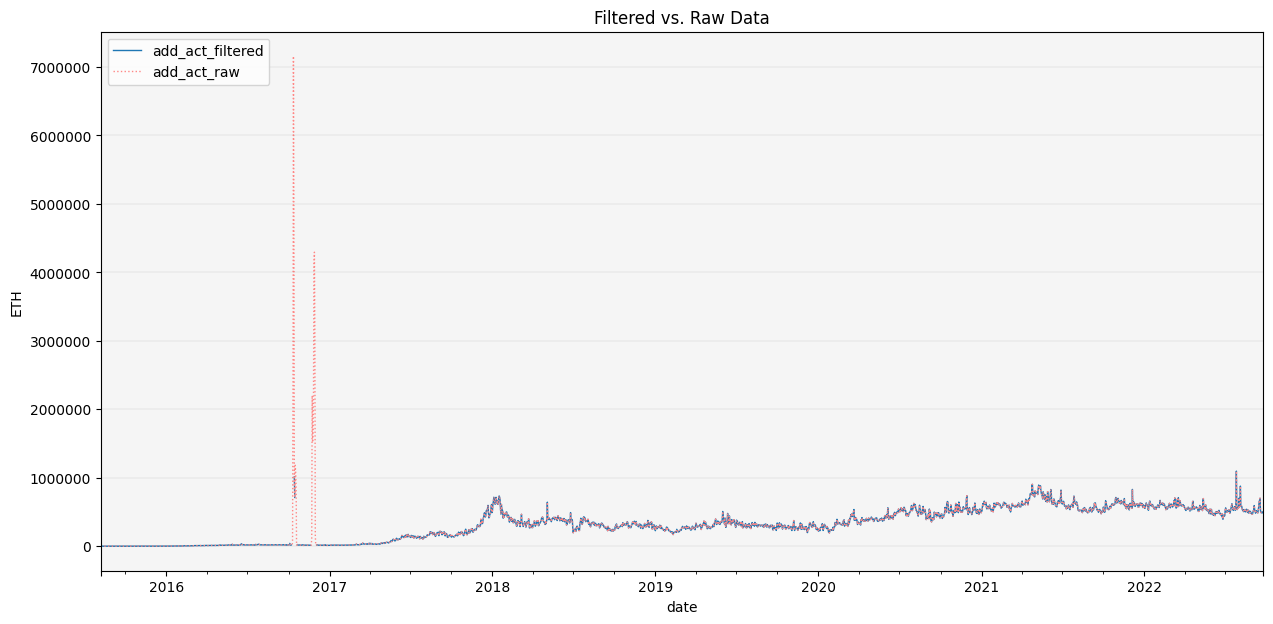

In [59]:
CleanData(df).filter_outliers(od_method='stl', thresh_val=20).show_plot(plot_series=('ETH', 'add_act'))

We can see that it goes a reasonably good job of identifying the large global outliers in active addresses for ETH in late 2017.

### Filter <a class="anchor" id="filter"></a>

In addition to filtering outliers, the `Filter` class has several methods allow us to remove data that isn't of interest to us in our analysis.

For example, let's say we only want assets with a mimimum of $10 mil USD of average traded volumne, and those with a minimum of 100 price close observations. We can run the `filter_avg_trading_val` and `filter_min_nobs` methods on the raw data.

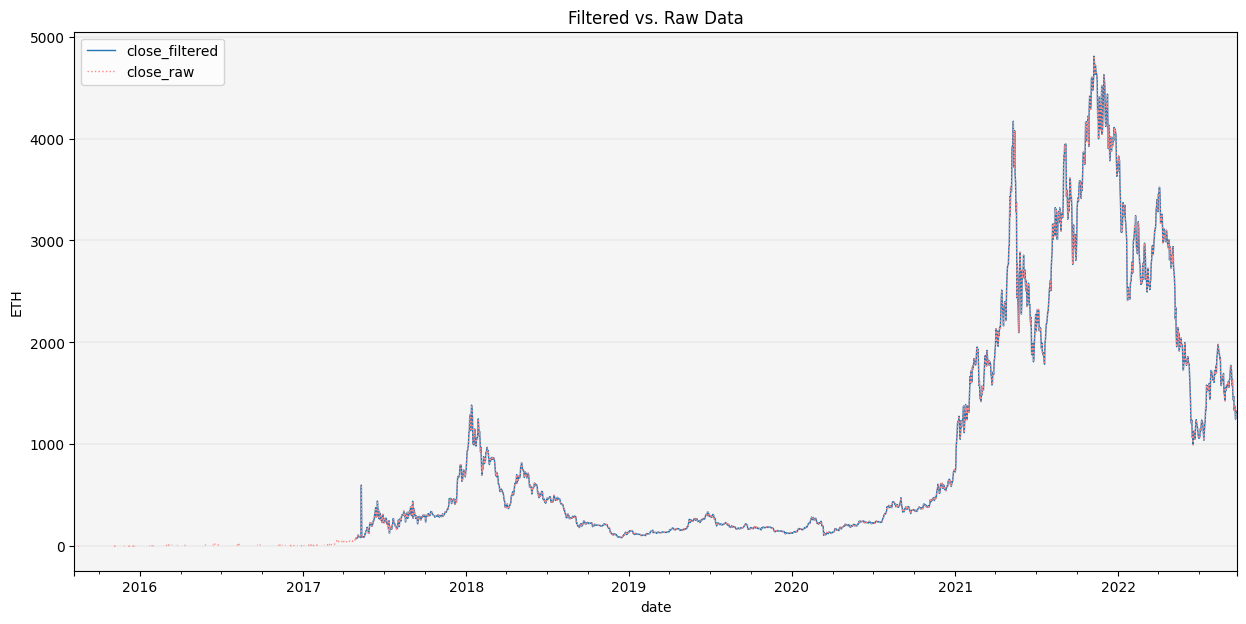

In [60]:
CleanData(df).filter_avg_trading_val(thresh_val=10000000, window_size=30).filter_min_nobs(min_obs=100).show_plot(plot_series=('ETH', 'close'))

We see that our filter removed values up to early 2017 since ETH didn't meet the minimum average trading value over a 30-day window.

### Impute <a class="anchor" id="impute"></a>

The `Impute` class has several methods that allow us to replace missing values which can cause many issues in predictive/ML models, e.g. scikit-learn and other ML packages may not like missing values and fail to run properly.

We can use it to impute/repair the missing vals/outliers from late 2017 for ETH active addresses with the `repair_outliers` method.

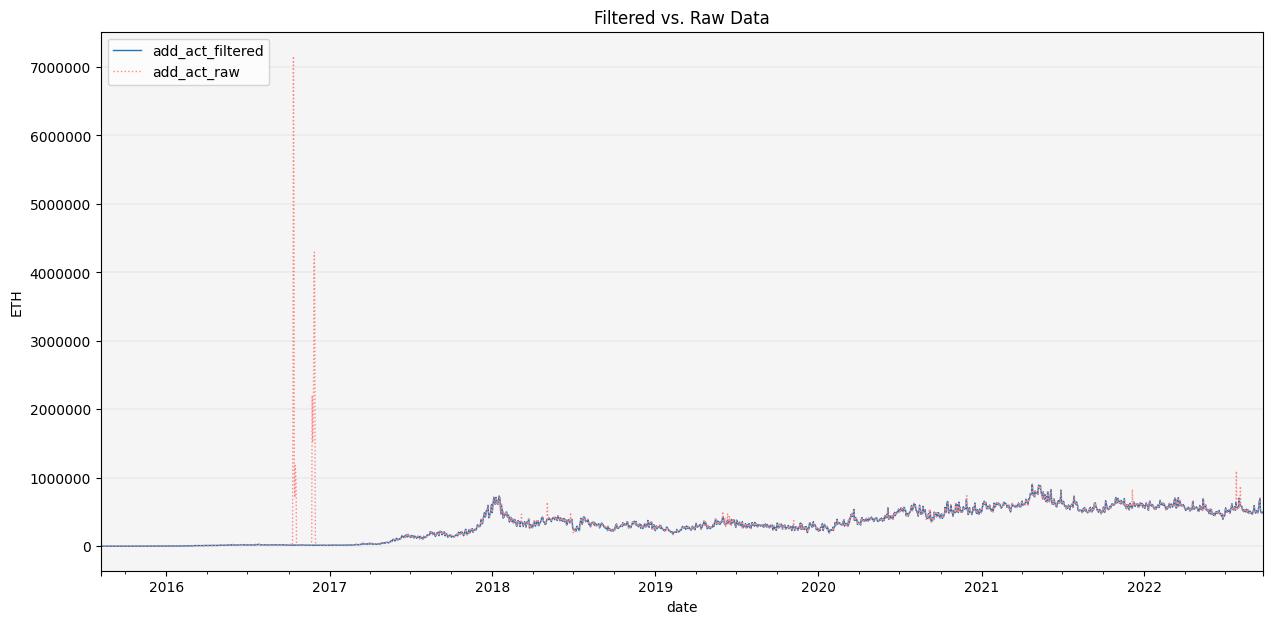

In [61]:
CleanData(df).filter_outliers(od_method='stl').\
              repair_outliers(imp_method='interpolate').\
              show_plot(plot_series=('ETH', 'add_act'))

### Clean Data <a class="anchor" id="clean-data"></a>

`CleanData` allows us to chain together a series of data cleaning operations and returns either a plot of the filtered vs. raw data, the clean data in a dataframe, the filtered outlies (and forecasts if applicable) and/or a summary of all the data cleaning operations and final data.

In [62]:
CleanData(df).filter_outliers(od_method='stl').\
              repair_outliers(imp_method='interpolate').\
              filter_avg_trading_val(thresh_val=10000000).\
              get(attr='summary')

close            volume           add_act         
                             BTC      ETH      BTC      ETH      BTC      ETH
n_obs                    2219.00  2197.00  2219.00  2197.00  5003.00  2605.00
%_NaN_start                55.74    56.17    55.74    56.17     0.20    48.04
%_outliers                  2.95     2.69     3.71     5.86     5.82     1.99
%_imputed                  14.84     8.96    15.52    13.86     5.86     2.01
%_below_avg_trading_val    20.61    11.57    20.53    13.31    64.29    13.46
%_NaN_end                  64.45    61.48    64.45    61.48    64.45    61.48

In [63]:
CleanData(df).filter_outliers(od_method='stl').\
              repair_outliers(imp_method='interpolate').\
              filter_avg_trading_val(thresh_val=10000000).\
              get(attr='df')

close      volume   add_act
date       ticker                                
2009-01-03 BTC         <NA>        <NA>      <NA>
2009-01-04 BTC         <NA>        <NA>      <NA>
2009-01-05 BTC         <NA>        <NA>      <NA>
2009-01-06 BTC         <NA>        <NA>      <NA>
2009-01-07 BTC         <NA>        <NA>      <NA>
...                     ...         ...       ...
2022-09-22 ETH      1326.49  2014394.01  486934.0
2022-09-23 BTC     19291.69   516380.61  987921.0
           ETH      1327.41  2004418.15  501558.0
2022-09-24 BTC     18933.57   326913.04  987921.0
           ETH      1317.49  1048714.12  501558.0

[7619 rows x 3 columns]